In [13]:
# Imports

import re
import numpy as np
import pandas as pd

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from pprint import pprint

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

import glob
import os

In [14]:
# Utility functions

def filenames_from_cat(top,second):
    cats_globs = glob.glob('./*/*/*.cats')
    matches = []
    for g in cats_globs:
        with open(g) as file:
            for line in file:
                line = line.split()[0]
                line = line.split(",")
                if int(line[0]) == top and int(line[1]) == second:
                    dir = os.path.basename(g)
                    filename = os.path.splitext(dir)[0]
                    matches.append(filename)
    
    return matches

def print_email_from_filename(filename):
    full_filename = glob.glob('./*/*/' + str(filename) + '.txt')
    with open(full_filename[0]) as file:
        for line in file:
            print(line)

def save_email_from_filename(filename):
    full_filename = glob.glob('./*/*/' + str(filename) + '.txt')
    email_contents = ""
    with open(full_filename[0]) as file:
        for line in file:
            email_contents = email_contents + line
    return email_contents

def save_all_from_cat(primary, secondary):
    filenames = filenames_from_cat(primary, secondary)
    contents = ""
    for file in filenames:
        contents = contents + save_email_from_filename(file)
        contents = contents + "\n" + ("*" * 100) + "\n\n"
    return contents

def list_all_filenames():
    globs = glob.glob('./*/*/*.cats')
    filenames = []
    for file in globs:
        filenames.append(os.path.splitext(os.path.basename(file))[0])
    return filenames

def length_of_email_from_filename(filename):
    email_text = save_email_from_filename(filename)
    tokenised = word_tokenize(email_text)
    return len(tokenised)

def number_of_recipients(filename):
    addresses = []
    contents = save_email_from_filename(filename)
    contents = contents.split("\n")
    for line in contents:
        if line.startswith("To:"):
            addresses.append(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line))
    
    return len([j for sub in addresses for j in sub])

def get_sender_from_filename(filename):
    addresses = []
    contents = save_email_from_filename(filename)
    contents = contents.split("\n")
    for line in contents:
        if line.startswith("From:"):
            addresses.append(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line))
    
    return [j for sub in addresses for j in sub][0]

In [15]:
# Get data

# Partition emails into sensitive and non-sensitive
sensitive_filenames = []
# Assume 'Purely personal' and 'Personal but in a professional context' are the sensitive categories
sensitive_filenames.append(filenames_from_cat(1,2))
sensitive_filenames.append(filenames_from_cat(1,3))
# Flatten the list
sensitive_filenames = [j for sub in sensitive_filenames for j in sub]
# Remove duplicates - 3 emails are counted in both categories
sensitive_filenames = list(dict.fromkeys(sensitive_filenames))

non_sensitive_filenames = []
for name in list_all_filenames():
    if name not in sensitive_filenames:
        non_sensitive_filenames.append(name)

all_emails = []

for filename in sensitive_filenames:
    email = save_email_from_filename(filename)
    all_emails.append(email)

for filename in non_sensitive_filenames:
    email = save_email_from_filename(filename)
    all_emails.append(email)

In [16]:
# Preprocess

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)
    
data_words = list(sent_to_words(all_emails))

In [17]:
# Bi and Tri gram models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [18]:
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.045*"power" + 0.032*"state" + 0.023*"price" + 0.019*"plant" + '
  '0.017*"electricity" + 0.017*"utility" + 0.015*"gas" + 0.015*"energy" + '
  '0.010*"natural" + 0.010*"generator"'),
 (1,
  '0.018*"employee" + 0.008*"access" + 0.008*"equity" + 0.006*"remain" + '
  '0.005*"trading" + 0.005*"service" + 0.005*"student" + 0.005*"test" + '
  '0.005*"contractor" + 0.005*"training"'),
 (2,
  '0.033*"plain_charset" + 0.021*"steven" + 0.021*"forward" + '
  '0.020*"cc_bcc_folder" + 0.020*"send" + 0.017*"attach" + 0.016*"pm" + '
  '0.015*"draft" + 0.015*"confidential" + 0.014*"notes_folder"'),
 (3,
  '0.017*"market" + 0.009*"time" + 0.008*"include" + 0.007*"issue" + '
  '0.007*"business" + 0.006*"week" + 0.006*"work" + 0.005*"well" + '
  '0.005*"provide" + 0.005*"project"')]


In [19]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=all_emails):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6514,"market, time, include, issue, business, week, ...","[pdt, confidential, business, proposal, plain_..."
1,1,3.0,0.6772,"market, time, include, issue, business, week, ...","[plain_charset, steven, advice, much, esteem, ..."
2,2,2.0,0.4338,"plain_charset, steven, forward, cc_bcc_folder,...","[message_id_date, anti, motivational, picture,..."
3,3,2.0,0.7709,"plain_charset, steven, forward, cc_bcc_folder,...","[message_id_date, plain_charset, steven, cc_bc..."
4,4,3.0,0.5115,"market, time, include, issue, business, week, ...","[aug_pdt, help, neighborhood, type_text, plain..."
5,5,2.0,0.4504,"plain_charset, steven, forward, cc_bcc_folder,...","[aug_pdt, slash, price, cap, plain_charset, st..."
6,6,3.0,0.4547,"market, time, include, issue, business, week, ...","[plain_charset, steven, kean, cc_bcc_folder, l..."
7,7,3.0,0.5109,"market, time, include, issue, business, week, ...","[aug_pdt, great, press, plain_charset, steven,..."
8,8,2.0,0.6066,"plain_charset, steven, forward, cc_bcc_folder,...","[fri_sep, pdt, test, message, plain_charset, s..."
9,9,2.0,0.7750,"plain_charset, steven, forward, cc_bcc_folder,...","[pdt, fwd, answer, plain_charset, steven, kean..."


In [20]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6603,"power, state, price, plant, electricity, utili...","[fri_sep, pdt, lawmaker, vote, limit, power, c..."
1,1.0,0.8168,"employee, access, equity, remain, trading, ser...","[confidential, information, security, trading,..."
2,2.0,0.9894,"plain_charset, steven, forward, cc_bcc_folder,...","[sun, apr_pdt, plain_charset, steven, kean, cc..."
3,3.0,0.8801,"market, time, include, issue, business, week, ...","[stand_alone, reliability, legislation, plain_..."


C:\Users\jack-\AppData\Local\Temp/ipykernel_21912/1624808892.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


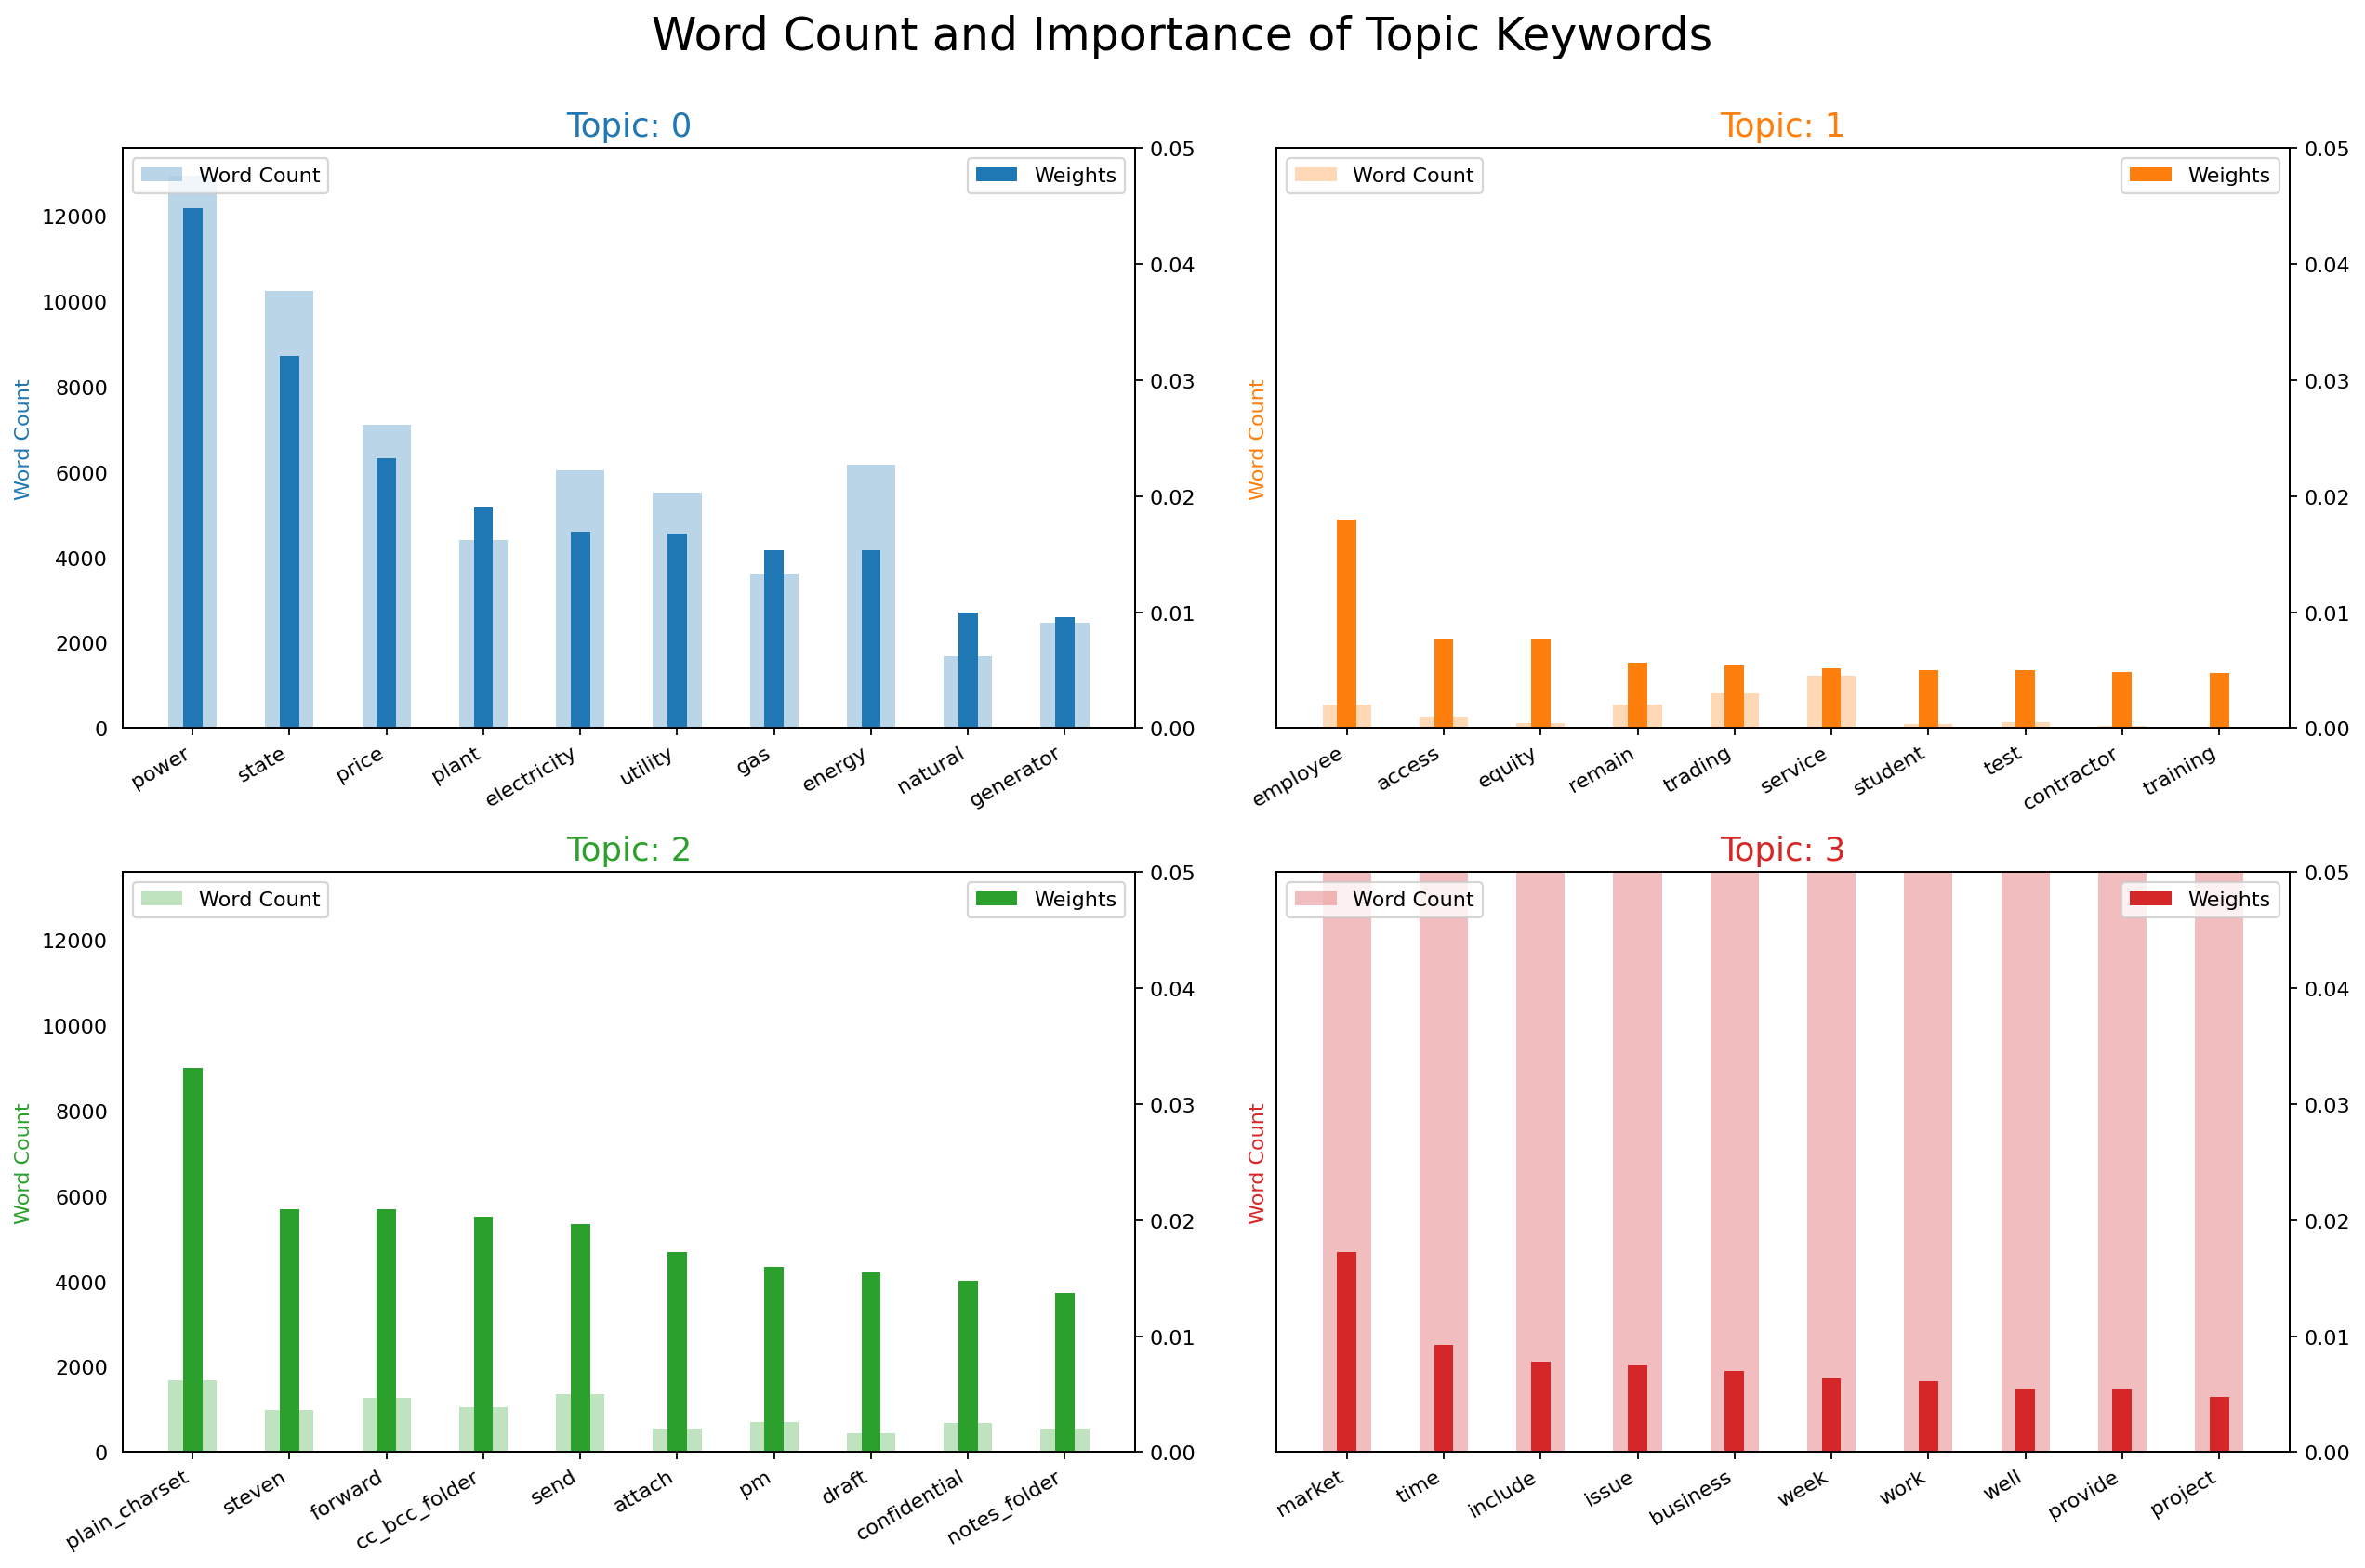

In [21]:
from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.05); ax.set_ylim(0, 10,000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

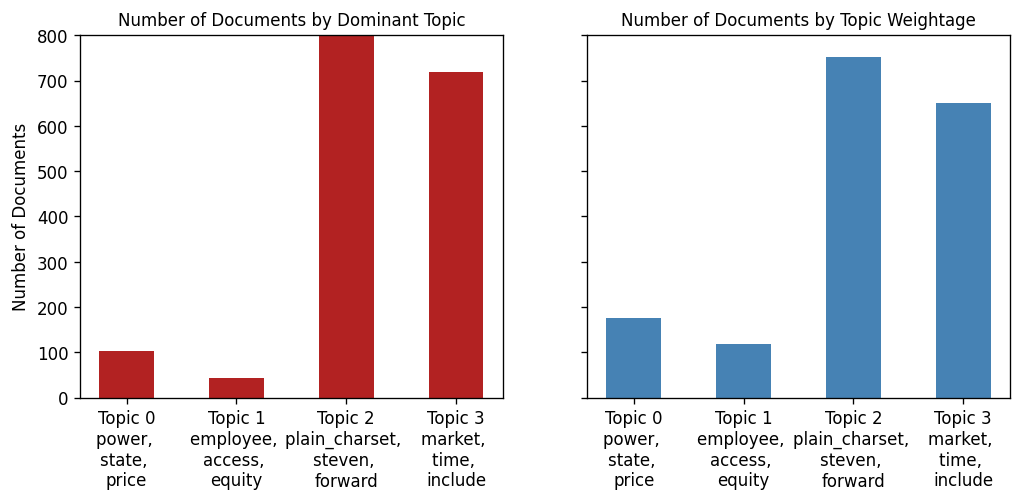

In [22]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 800)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
lda_viz

C:\Users\jack-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\jack-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.296425  0.012951       1        1  43.639122
3     -0.005715 -0.228927       2        1  43.162363
2      0.267437 -0.021330       3        1   7.630957
1      0.034703  0.237307       4        1   5.567558, topic_info=               Term          Freq         Total Category  logprob  loglift
775           power  12852.000000  12852.000000  Default  30.0000  30.0000
612           state   9184.000000   9184.000000  Default  29.0000  29.0000
1414          plant   5442.000000   5442.000000  Default  28.0000  28.0000
301           price   7015.000000   7015.000000  Default  27.0000  27.0000
87    plain_charset   1697.000000   1697.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
843            link    116.011900    279.911752   Topic4  -5.7530   2.0074
2299         policy    139.152368    934.309845   Topic4  -5.5712   0.9840
257          office    139.001733   1155.860414   Topic4  -5.5722   0.7701
214        chairman    117.194186    377.695662   Topic4  -5.7429   1.7180
282            year    134.059994   3423.078706   Topic4  -5.6084  -0.3518

[232 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6650      1  0.009522      aa
6650      2  0.009522      aa
6650      4  0.971259      aa
2178      1  0.002475  access
2178      2  0.306842  access
...     ...       ...     ...
282       2  0.322809    year
282       4  0.039146    year
814       1  0.010214   young
814       2  0.010214   young
814       4  0.970338   young

[660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])